In [1]:
# Ithil behaviours configuration.
# Here we configue the main Ithil parameters before
# running the simulation.

from random import gauss, uniform
from typing import Tuple

from palantir.oracle import PriceOracle
from palantir.types import Currency, Position
from palantir.util import Percent


def slippage(price: float) -> float:
    DESIRED_MAX_SLIPPAGE_PERCENT = 1.0
    return gauss(price, price * DESIRED_MAX_SLIPPAGE_PERCENT / 100.0)


def calculate_fees(position: Position) -> float:
    return Percent(0.2).of(position.collateral)


def calculate_interest_rate(
    src_token: Currency,
    dst_token: Currency,
    collateral: float,
    principal: float,
):
    return 0.0


def calculate_liquidation_fee(position: Position) -> float:
    return 0.0


def split_fees(fees: float) -> Tuple[float, float]:
    return (fees / 2.0, fees / 2.0)


def calculate_collateral_usd(price_oracle, token) -> float:
    return (abs(gauss(mu=3000, sigma=5000)) + 100.0) / price_oracle.get_price(token)


def calculate_leverage() -> float:
    return uniform(1.0, 10.0)


print("Ready")

Ready


In [2]:
# Simulation.
# Here we build the simulation data and assemble
# the desired Ithil and traders objects.
# Finally we run the simulation and collect the results.

from random import uniform
from typing import List

from palantir.clock import Clock
from palantir.ithil import Ithil
from palantir.metrics import (
    Metric,
    Metrics,
    MetricsAggregatorSum,
    MetricsLogger,
    make_timeseries,
)
from palantir.oracle import PriceOracle
from palantir.palantir import Palantir
from palantir.simulation import Simulation
from palantir.trader import Trader
from palantir.types import (
    Account,
    Currency,
)
from palantir.util import (
    init_price_db,
    make_trader_names,
    read_quotes_from_db,
)


HOURS = 2000
TOKENS = [
    Currency("bitcoin"),
    Currency("ethereum"),
    Currency("dai"),
]

TRADERS_NUMBER = 10
SIMULATIONS_NUMBER = 100


db = init_price_db(TOKENS, HOURS)


def build_simulation():
    clock = Clock(HOURS)

    metrics_logger = MetricsLogger(clock)
    price_oracle = PriceOracle(
        clock=clock,
        quotes={
            token: read_quotes_from_db(db, token, HOURS)
            for token in TOKENS
        },
    )
    ithil = Ithil(
        apply_slippage=slippage,
        calculate_fees=calculate_fees,
        calculate_interest_rate=calculate_interest_rate,
        calculate_liquidation_fee=calculate_liquidation_fee,
        clock=clock,
        insurance_pool={
            Currency("bitcoin"): 0.0,
            Currency("dai"): 0.0,
            Currency("ethereum"): 0.0,
        },
        metrics_logger=metrics_logger,
        price_oracle=price_oracle,
        split_fees=split_fees,
        vaults={
            Currency("bitcoin"): 7.0,
            Currency("dai"): 750000.0,
            Currency("ethereum"): 300.0,
        },
    )
    simulation = Simulation(
        clock=clock,
        ithil=ithil,
        traders=[
            Trader(
                account=Account(trader_name),
                open_position_probability=0.1,
                close_position_probability=0.1,
                ithil=ithil,
                calculate_collateral_usd=calculate_collateral_usd,
                calculate_leverage=calculate_leverage,
                liquidity={
                    Currency("bitcoin"): 0.0,
                    Currency("dai"): 1000.0,
                    Currency("ethereum"): 1.0,
                },
            )
            for trader_name in make_trader_names(TRADERS_NUMBER)
        ],
    )

    return simulation


palantir = Palantir(
    simulation_factory=build_simulation,
    simulations_number=SIMULATIONS_NUMBER,
)

simulations_metrics = palantir.run()


print(f"Completed {len(simulations_metrics)} simulations")

Completed 100 simulations


In [ ]:
# Plot number of open positions per hour

import random
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 8]  # Make the default plot wider
plt.rcParams['figure.dpi'] = 120  # Increase default plot resolution

COLORS = ["b-", "g-", "r-", "c-", "m-", "y-", "k-"]

opened_positions = [
    make_timeseries(
        metrics,
        Metric.POSITION_OPENED,
        MetricsAggregatorSum(),
        HOURS,
    )
    for metrics in simulations_metrics
]

for samples in opened_positions:
    plt.plot(samples, random.choice(COLORS))
    
plt.show()

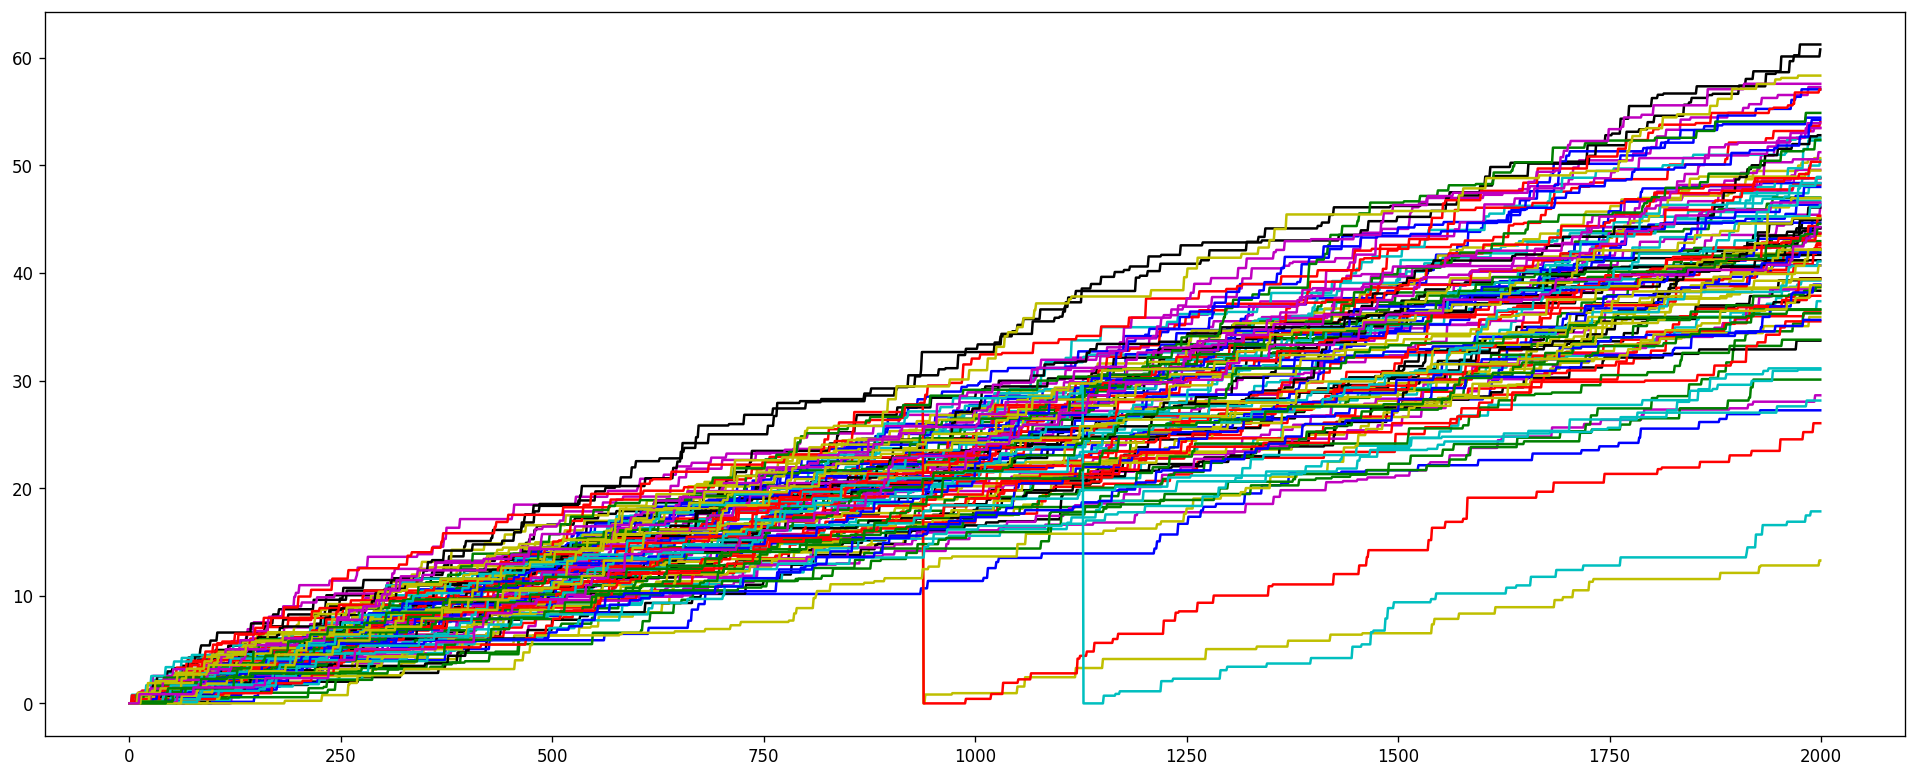

In [3]:
# Plot insurance pool liquidity over time (DAI)

import random
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 8]  # Make the default plot wider
plt.rcParams['figure.dpi'] = 120  # Increase default plot resolution

COLORS = ["b-", "g-", "r-", "c-", "m-", "y-", "k-"]

timeseries = [
    make_timeseries(
        metrics,
        Metric.INSURANCE_POOL_LIQUIDITY_DAI,
        MetricsAggregatorSum(),
        HOURS,
    )
    for metrics in simulations_metrics
]

for samples in timeseries:
    plt.plot(samples, random.choice(COLORS))
    
plt.show()